# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from skorch import NeuralNetRegressor

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


How to load the data:

In [3]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [4]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

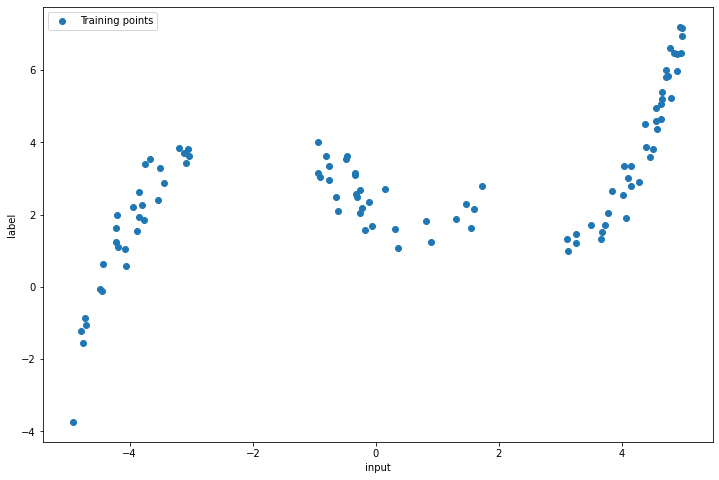

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

## Network definition

In [6]:
class Net(nn.Module):
    """
    Network with customizable set of hidden layers
    """
    def __init__(self, N_in, N_hid, N_out, act_func = nn.Sigmoid(), dropout = 0, act_output = False):
        """
        Initialization function for the network
        
        Paramters
        ----------
        
        N_in: Input layer size
        N_out: Output layer size
        N_hid: Array containing sizes of hidden layers
        act_func: Activation function
        dropout: Activate dropout between hidden layers
        
        """
        super().__init__()
        
        self.hid_layers = []
        self.hid_layers.append(nn.Linear(in_features=N_in, out_features=N_hid[0]))
        for i in range(1,len(N_hid)):
            self.hid_layers.append(nn.Linear(in_features=N_hid[i-1], out_features=N_hid[i]))
            
        self.out_layer = nn.Linear(in_features=N_hid[-1], out_features=N_out)
        self.act = act_func
        
        self.drop_func = nn.Dropout(dropout)
        
        self.act_output = act_output
        print('Network initialized')
        
    def forward(self, x):
        for layer in self.hid_layers:
            x = self.act(layer(x))  
            x = self.drop_func(x)
  
        x = self.out_layer(x)
        
        if self.act_output == True:
            x = self.act(x)
        return x

## Network initialization

In [15]:
torch.manual_seed(0)
N_in = 1
N_hid = [50,100]
N_out = 1
net = Net(N_in, N_hid, N_out,dropout=0.02, act_func=nn.ReLU())

net_skorch = NeuralNetRegressor(
            Net,
            criterion= nn.MSELoss,
            max_epochs=5000,
            lr = 1e-4,
            optimizer =optim.Adam,
            train_split=None
#            device='cuda',  # uncomment this to train with CUDA
)

Network initialized


## Dataset initialization

In [16]:
input_data = torch.tensor(train_df["input"].to_numpy().reshape([-1,1]),dtype=torch.float32)
label_data =  torch.tensor(train_df["label"].to_numpy().reshape([-1,1]), dtype=torch.float32)

## GridSearch

In [21]:
params = {
    'lr': [0.01, 0.02,1e-3,1e-4,5e-4,5e-4,0.05],
    'max_epochs': [100, 500, 1000, 2000,4000],
    'N_in' : [1],
    'N_out' : [1],
    'N_hid' : np.array(list(itertools.product(np.linspace(2,100,10),np.linspace(2,100,10)))),
    'act_func' : [nn.Sigmoid(),nn.ReLU(),nn.LeakyReLU(),nn.Softmax()],
    'dropout' : np.arange(0,1,0.1),
    'act_output' : [False, True],
}
rs = RandomizedSearchCV(estimator = net_skorch, 
                   param_distributions = params, 
                   cv = 5, n_iter = 100)
rs.fit(input_data, label_data)
print(gs.best_score_, gs.best_params_)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [20]:
"module_dropout" in net_skorch.get_params().keys() 

False

## Training

In [43]:
net_skorch.fit(input_data, label_data)

  epoch    train_loss     dur
-------  ------------  ------
      1       10.7866  0.0081
      2       10.7940  0.0061
      3       10.7420  0.0044
      4       10.6816  0.0045
      5       10.7139  0.0031
      6       10.7842  0.0030
      7       10.8062  0.0020
      8       10.6748  0.0010
      9       10.6799  0.0040
     10       10.6104  0.0040
     11       10.6840  0.0060
     12       10.6928  0.0061
     13       10.6499  0.0021
     14       10.6011  0.0047
     15       10.5568  0.0031
     16       10.5910  0.0065
     17       10.5654  0.0039
     18       10.4953  0.0031
     19       10.4855  0.0050
     20       10.4936  0.0030
     21       10.4352  0.0030
     22       10.5242  0.0060
     23       10.4646  0.0059
     24       10.3383  0.0061
     25       10.3886  0.0038
     26       10.3764  0.0039
     27       10.3390  0.0042
     28       10.3840  0.0031
     29       10.3867  0.0049
     30       10.3040  0.0033
     31       10.3694  0.0047
     32   

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (out_layer): Linear(in_features=100, out_features=1, bias=True)
    (act): ReLU()
    (drop_func): Dropout(p=0.02, inplace=False)
  ),
)

## Losses

In [44]:
train_loss = net_skorch.history[:, 'train_loss']
val_loss = net_skorch.history[:, 'valid_loss']

KeyError: "Key 'valid_loss' was not found in history."

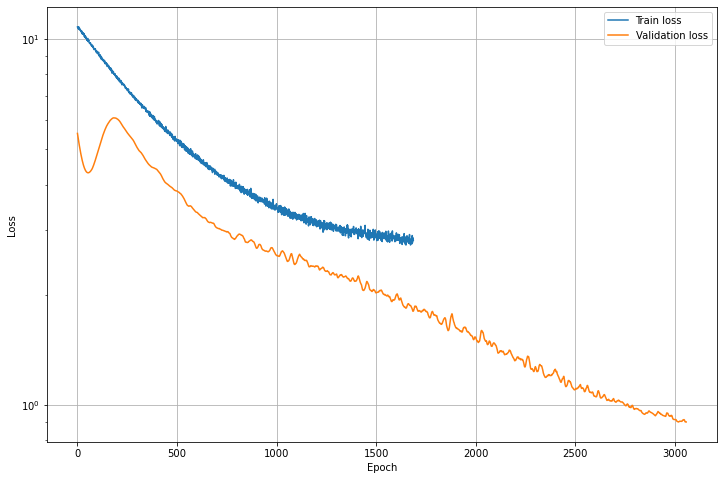

In [45]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Result

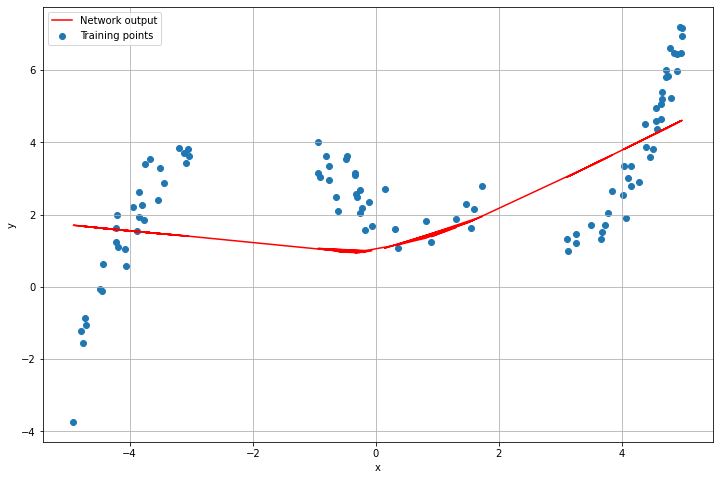

In [46]:
# Convert x_vec and y_vec to numpy one dimensional arrays
y_vec = net_skorch.predict(torch.tensor(train_df["input"].to_numpy().reshape([-1,1]),dtype=torch.float32))

# Plot output
plt.figure(figsize=(12,8))
plt.plot(train_df.input, y_vec, label='Network output', c = "Red")
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

Download the dataset:

In [7]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data\FashionMNIST\raw\train-images-idx3-ubyte.gz to classifier_data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to classifier_data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to classifier_data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to classifier_data\FashionMNIST\raw



How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


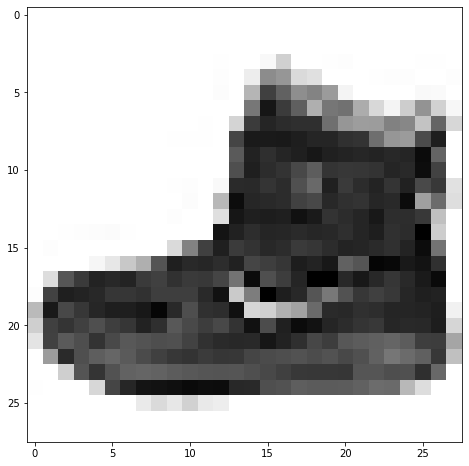

In [8]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [9]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [10]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32
